In [3]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.colors import LogNorm
import os
import seaborn as sns
import scipy.stats

import pandas as pd

dfs = []
for chrom in range(1, 23):
    if not os.path.exists("chr%s.period.tab"%chrom): continue
    data = pd.read_csv("chr%s.stats.tab"%chrom, sep="\t")
    dfs.append(data)
data = pd.concat(dfs)

motifs = pd.read_csv("motif_info.tab", sep="\t", names=["chrom", "start","period","motif"])
data = pd.merge(data, motifs, on=["chrom","start"])
data["reflen"] = data.apply(lambda x: (x["end"]-x["start"]+1)/x["period"], 1)
data

Populating the interactive namespace from numpy and matplotlib


,chrom,start,end,nalleles-ALL,nalleles-EUR,nalleles-EAS,nalleles-SAS,nalleles-AMR,nalleles-AFR,nalleles-H3A,het-ALL,het-EUR,het-EAS,het-SAS,het-AMR,het-AFR,het-H3A,period,motif,reflen
0,chr1,899025,899048,2,2,2,2,2,2,3,0.402000,0.41300,0.289,0.425,0.442,0.420,0.593,1.0,A,24.000000
1,chr1,902774,902789,2,2,3,2,2,2,2,0.489000,0.35400,0.482,0.373,0.484,0.519,0.526,1.0,A,16.000000
2,chr1,904654,904666,1,1,2,2,1,2,1,0.104000,0.03420,0.123,0.135,0.067,0.139,0.115,3.0,AGG,4.333333
3,chr1,907237,907251,2,2,2,2,2,2,2,0.489000,0.40500,0.489,0.502,0.437,0.498,0.500,1.0,A,15.000000
4,chr1,907539,907563,4,3,3,4,4,4,4,0.652000,0.51700,0.640,0.666,0.604,0.715,0.754,1.0,A,25.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189418,chr2,62371781,62371792,2,2,2,2,2,2,2,0.365000,0.20600,0.412,0.398,0.356,0.401,0.424,1.0,A,12.000000
189419,chr2,62373551,62373573,4,3,4,4,4,4,3,0.725000,0.58700,0.704,0.710,0.690,0.680,0.672,1.0,A,23.000000
189420,chr2,62375575,62375604,1,1,1,1,1,1,1,0.000313,0.00158,0.000,0.000,0.000,0.000,0.000,6.0,AAAAAC,5.000000
189421,chr2,62378877,62378889,1,1,1,1,1,1,1,0.000000,0.00000,0.000,0.000,0.000,0.000,0.000,4.0,AAAG,3.250000


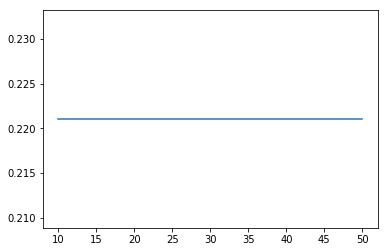

In [5]:
# Plot reflen vs. het by period, overall and for each population

def GetMatchesMotif(motif, motiflist):
    for m in motiflist:
        if m == "ALL": return True
        elif type(m) == int:
            if len(motif)==m: return True
        elif m == "vntr":
            if len(motif)> 6: return True
        else:
            if m == motif: return True
    return False
    
def PlotLenVsHet(data, pop=None, motifs=None):
    """
    Plot length vs. het
    If pop=None, use het-ALL. else use het-${pop}
    motifs is a list of motifs. or 1, 2, 3 etc. for
    all motifs with that length. Use "vntr" for 7+
    """
    MINLEN = 10
    MAXLEN = 50
    if pop is None:
        col = "het-ALL"
    else: col = "het-%s"%pop
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if motifs is None: motifs = ["ALL"]
    for m in motifs:
        xvals = []
        yvals = []
        for l in range(MINLEN, MAXLEN+1):
            xvals.append(l)
            yvals.append(np.mean(data[data["motif"].apply(lambda x: GetMatchesMotif(x, [m]), 1)][col]))
        ax.plot(xvals, yvals)
        
PlotLenVsHet(data)